# Set up

In [12]:
import pandas as pd
from pyspark.sql import Window
from pyspark.sql.functions import coalesce, concat, lag, lit, lower, sum, unix_timestamp, max, min, \
                                  sin, cos, atan, sqrt, atan2, toRadians, round

from classes import StravaLoader

%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

# Load data

In [13]:
# Initialize Strava activity loader
sl = StravaLoader('s3', 'strava-activities', sc=sc, hiveContext=sqlContext)

# Load the dataset
df = sl.get_dataset()

Info: Using supplied SparkContext and HiveContext


# Analysis
### Parameters

In [14]:
stage_gap_min = 10

## Calculate additional columns

In [15]:
# Partitioning on <athlete> and <activity_type>
window = Window.partitionBy('athlete', 'activity_type').orderBy('unix_time')

# Timestamp in seconds
df = df.withColumn( 
    'unix_time', 
    unix_timestamp(df['time'], "yyyy-MM-dd'T'HH:mm:ss'Z'")
) 

# Time difference in seconds between tracking point and previous tracking point
df = df.withColumn(
    'unix_time_diff',
    df['unix_time'] - lag('unix_time', count=1).over(window)
)

# Indicator (0,1) of whether time difference is greater than threshold (new activity block)
df = df.withColumn(
    'CALC_block_isnew',
    coalesce(
        (df['unix_time_diff'] >= stage_gap_min * 60).cast('integer'),
        lit(0)
    )
)

# Sequence number of activity block per athlete and activity 
df = df.withColumn(
    'CALC_block_seqnum', 
    sum('CALC_block_isnew').over(window)
)

# Activity block id "<athlete>_<activity_type>_<integer>"
df = df.withColumn(
    'CALC_block_id',
    concat(
        df['athlete'],
        lit('_'),
        lower(df['activity_type']),
        lit('_'),
        df['CALC_block_seqnum'].cast('string')
    )
)

## Flatten DataFrame

In [16]:
dff = df.select( 
    df['@lat'].alias('lat'), 
    df['@lon'].alias('lon'), 
    df['ele'].alias('ele'), 
    df['extensions.gpxtpx:TrackPointExtension.gpxtpx:atemp'].alias('atemp'), 
    df['extensions.gpxtpx:TrackPointExtension.gpxtpx:cad'].alias('cad'), 
    df['extensions.gpxtpx:TrackPointExtension.gpxtpx:hr'].alias('hr'), 
    df['time'].alias('time'), 
    df['unix_time'].alias('time_seconds'),
    df['athlete'].alias('athlete'), 
    df['activity_type'].alias('activity_type'),
    df['CALC_block_id'].alias('block_id')
)

# Output

In [17]:
R = 6371000 # Earth radius
window2 = Window.partitionBy('block_id').orderBy('time_seconds')

dffr = dff

dffr = dffr.withColumn(
    'latR',
    toRadians(dffr['lat'])
)

dffr = dffr.withColumn(
    'lonR',
    toRadians(dffr['lon'])
)

dffr = dffr.withColumn(
    'latR_prev',
    lag('latR', count=1).over(window2)
)

dffr = dffr.withColumn(
    'lonR_prev',
    lag('lonR', count=1).over(window2)
)

dffr = dffr.withColumn(
    'latR_diff',
    coalesce(dffr['latR'] - dffr['latR_prev'], lit(0))
)

dffr = dffr.withColumn(
    'lonR_diff',
    coalesce(dffr['lonR'] - dffr['lonR_prev'], lit(0))
)

dffr = dffr.withColumn(
    'a',
    sin(dffr['latR_diff']/2) * sin(dffr['latR_diff']/2)
    + cos(dffr['latR']) * cos(dffr['latR_prev'])
    * sin(dffr['lonR_diff']/2) * sin(dffr['lonR_diff']/2)
)

dffr = dffr.withColumn(
    'c',
    2 * atan2(sqrt(dffr['a']), sqrt(1 - dffr['a']))
)

dffr = dffr.withColumn(
    'dist_diff',
    coalesce(R * dffr['c'], lit(0))
)

dffr = dffr.withColumn(
    'dist_cum_km',
    sum('dist_diff').over(window2) / 1000
)

dffr = dffr.withColumn(
    'speed_kmh',
    coalesce(
        3.6 * dffr['dist_diff'] / (dffr['time_seconds'] - lag('time_seconds', count=1).over(window2)),
        lit(0)
    )
)

#dffr.select(
#    dffr['block_id'],
#    dffr['time'],
#    dffr['latR'],
#    dffr['lonR'],
#    dffr['dist_diff'],
#    dffr['dist_cum_km'],
#    dffr['speed_kmh']
#).orderBy(['athlete', 'activity_type', 'time_seconds']).show()

<Container object of 80 artists>

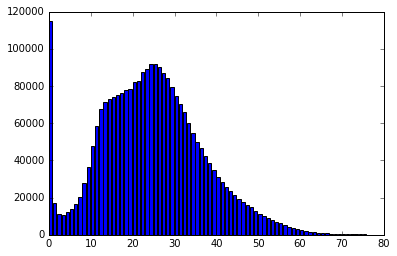

In [18]:
sp = dffr.filter('activity_type="Ride"').select(round(dffr['speed_kmh']).alias('speed_int')).groupBy('speed_int').count().filter('speed_int<80').toPandas()
plt.bar(sp['speed_int'], sp['count'])

In [66]:
dfa = dffr.groupBy('block_id').agg(
    ((max(dffr['time_seconds']) - min(dffr['time_seconds']))/60).alias('block_minutes'),
    max(dffr['dist_cum_km']).alias('block_dist')
)

dfa = dfa.withColumn(
    'avg_speed',
    dfa['block_dist'] / (dfa['block_minutes'] / 60)
)

pdf = dfa.toPandas()

pdf